## 19 Century English Children's Literature Corpus¶

### Import packages and create stopword list

In [1]:
import os
import glob

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'would', 'could', 'get'
                   , 'come', 'may', 'say', 'jennie', 'nutkin', 'gluck', 'arbor', 'smooch', 'hunca_munca', 
                   'lily', 'crosbie', 'same', 'bernard', 'johnny', 'cradell', 'hopkin', 'lily_dale', 'griseld', 'allan', 'alice', 'noel',
                   'robert', 'dicky', 'alicia', 'cuckoo', 'cnut', 'norman', 'deronda', 'harry, margaret', 'gwendolen', 'ethel', 'isabel',
                   'toady_lion', 'dissy', 'madame_merle', 'lord_warburtan', 'pansy', 'isabel', 'barrymore', 'sir_charle', 'dr_mortimer',
                   'watson', 'moor', 'catherine', 'heathcliff', 'linton', 'great', 'never','much','shall','well', 'find', 'give', 'ebbo','grandcourt', 'william',
                  'mary','quite','turn','maisie','thornton','philip', 'dorothea', 'tom','_', 'loman', 'doctor','oliver','stephen','maggie','tess','back', 
                  'little', 'thing', 'ready', 'cuthberg','make','must','pass','jurgi', 'osborne','marija',
                  'rawdon','vivian', 'miss_halcombe','jos','osborne', 'fairlie', 'beckendorff',
                  'lady_glyde', 'sir_percival', 'crawley'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
textfiles = glob.glob("ChiLit/*txt") # list files in local directory  

In [3]:
textList=[]
for textFile in textfiles: # create a list 
    f = open(textFile, "r")
    textList = textList + [f.read().upper()]
    f.close()
len(textList)

71

## Pre-processing the texts

### First, I tokenize the texts, removing punctuation and unnessecary characters

In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
data_words = list(sent_to_words(textList))

In [5]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

### Building bigram and trigram models, words that are likely to occur together

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Remove stopwords, make bigrams and bigrams and lemmatize¶ (only keeping nouns)

In [7]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### Create dictionary and corpus needed for the Topic Model, build LDA model¶

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           update_every=1,
                                           chunksize=1000,
                                           passes=4,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

### View 20 most important topics 

In [9]:
pprint(lda_model.print_topics())

[(0,
  '0.011*"time" + 0.011*"boy" + 0.009*"man" + 0.009*"day" + 0.008*"diamond" + '
  '0.007*"hand" + 0.007*"father" + 0.007*"way" + 0.007*"horse" + '
  '0.006*"mother"'),
 (1,
  '0.015*"guy" + 0.011*"time" + 0.010*"flora" + 0.009*"day" + 0.008*"harry" + '
  '0.008*"laura" + 0.008*"father" + 0.007*"hand" + 0.007*"way" + 0.006*"papa"'),
 (2,
  '0.006*"man" + 0.005*"thumb" + 0.005*"time" + 0.005*"way" + 0.004*"day" + '
  '0.004*"boy" + 0.004*"house" + 0.003*"place" + 0.003*"night" + 0.003*"hand"'),
 (3,
  '0.011*"nod" + 0.010*"eye" + 0.010*"child" + 0.010*"time" + 0.010*"day" + '
  '0.008*"hand" + 0.008*"water" + 0.007*"head" + 0.007*"night" + 0.007*"way"'),
 (4,
  '0.021*"giglio" + 0.017*"king" + 0.012*"prince" + 0.009*"princess" + '
  '0.008*"queen" + 0.008*"bulbo" + 0.008*"betsinda" + 0.006*"time" + '
  '0.006*"hand" + 0.006*"gruffanuff"'),
 (5,
  '0.013*"time" + 0.009*"mother" + 0.008*"man" + 0.008*"boy" + 0.008*"day" + '
  '0.007*"jack" + 0.007*"way" + 0.007*"child" + 0.006*"hand" 

# Visualization

## Word clouds of top n keywords in each topic

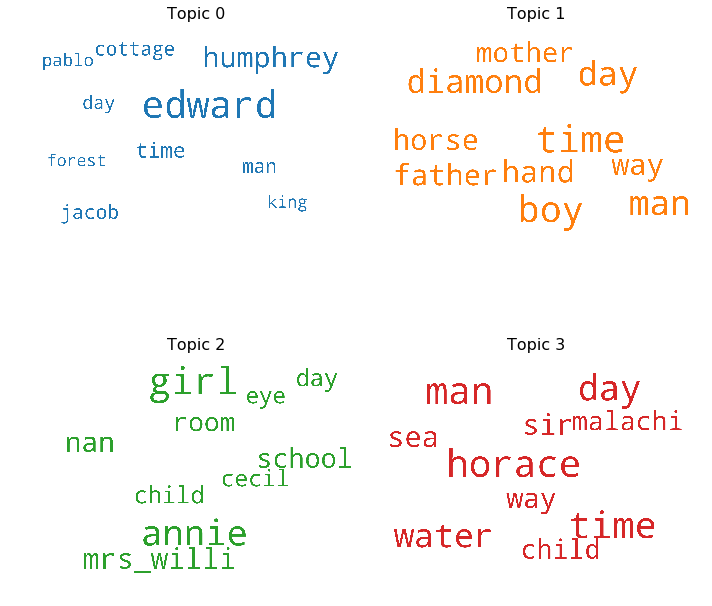

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Dominant topic and its percentage contribution in each document

In [13]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=textList):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5434,"time, mother, man, boy, day, jack, way, child, hand, peter","[adventure, wonderland, carroll, chapter, rabbit, hole, sister, bank, nothing, book, sister, pic..."
1,1,3.0,0.5606,"nod, eye, child, time, day, hand, water, head, night, way","[london, hesba, stretton, chapter, sultry, day, dog, day, country, dusky, leaf, sunrise, bird, s..."
2,2,14.0,0.9999,"king, time, stalky, head, cyril, queen, child, beetle, man, boy","[story, amulet, nesbit, wallis, british_museum, gratitude, kindness, help, chapter, child, summe..."
3,3,0.0,0.9999,"time, boy, man, day, diamond, hand, father, way, horse, mother","[beauty, mother, life, pen, welfare, book, part, chapter, home, place, meadow, pond, water, tree..."
4,4,11.0,0.9999,"man, horace, time, day, water, sea, sir, way, child, malachi","[anstey, chapter, horace, commission, day, six_week, watch, half, half, window, office, cloister..."
5,5,5.0,0.9965,"time, mother, man, boy, day, jack, way, child, hand, peter","[beatrix_potter, child, mr, bunny, book, morning, rabbit, bank, ear, trot, trit, trot, pony, gig..."
6,6,11.0,0.7208,"man, horace, time, day, water, sea, sir, way, child, malachi","[settler, captain, marryat, bee, chapter, year, family, canada, province, year, year, emigrate, ..."
7,7,8.0,0.9998,"boy, time, day, way, griselda, room, school, door, nothing, hand","[carved_lion, molesworth, chapter, day, time, girl, world, time, childhood, case, remembrance, y..."
8,8,9.0,0.9956,"man, charlie, time, day, gun, fire, troop, place, force, tim","[preface, page, picture, event, year, commencement, calcutta, mercy, influence, extinction, indi..."
9,9,12.0,0.9897,"jack, peterkin, man, time, sea, island, water, day, hand, boat","[ballantyne, preface, boy, adventure, herein, memory, feeling, book, boy, hope, information, ple..."


## The most representative sentence for each topic

In [14]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,1.0000,"time, boy, man, day, diamond, hand, father, way, horse, mother","[schoolday, thoma, chapter, family, poet, horse, vale, sir, notion, cap, ballad, brown, pen, tha..."
1,1.0,1.0000,"guy, time, flora, day, harry, laura, father, hand, way, papa","[daisy_chain, charlotte, preface, author, overgrown, book, class, elder, series, sketch, story, ..."
2,2.0,0.9957,"man, thumb, time, way, day, boy, house, place, night, hand","[mouse, beatrix_potter, book, time, doll, house, brick, window, muslin, door, chimney, doll, luc..."
3,3.0,0.9999,"nod, eye, child, time, day, hand, water, head, night, way","[mulla_mulgar, walter, chapter, border, forest, fruit, monkey, name, mutt, son, thimbulla, nizza..."
4,4.0,0.9999,"giglio, king, prince, princess, queen, bulbo, betsinda, time, hand, gruffanuff","[ring, makepeace, thackeray, prelude, christma, season, city, child, city, child, party, night, ..."
5,5.0,0.9999,"time, mother, man, boy, day, jack, way, child, hand, peter","[railway, child, son, paul, bland, knowledge, railway, ignorance, shelter, chapter, railway, chi..."
6,6.0,1.0000,"man, hand, time, way, day, eye, place, water, night, king","[inscribe, book, adventure, son, arthur, rider, hope, day, boy, thought, herein, something, rank..."
7,7.0,0.9999,"man, king, day, time, alan, people, hand, house, queen, way","[louis, stevenson, preface, preface, edition, husband, writing, play, bournemouth, number, title..."
8,8.0,0.9999,"boy, time, day, way, griselda, room, school, door, nothing, hand","[crofton, boy, martineau, chapter, proctor, phil, mr_proctor, chemist, druggist, shop, strand, l..."
9,9.0,0.9956,"man, charlie, time, day, gun, fire, troop, place, force, tim","[preface, page, picture, event, year, commencement, calcutta, mercy, influence, extinction, indi..."


## pyLDAVIS: Visualise the information contained in a topic

In [21]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022261  0.002771       1        1  15.541279
1     -0.068544 -0.043213       2        1  13.158685
5     -0.010755  0.024306       3        1   9.726424
8     -0.087977 -0.010669       4        1   6.317209
3     -0.036811  0.043709       5        1   6.292509
11     0.012527  0.013112       6        1   6.266470
6      0.041109  0.035315       7        1   5.357511
14    -0.045908  0.022854       8        1   4.562589
17    -0.013590 -0.012294       9        1   4.295965
7      0.024561 -0.020356      10        1   3.966653
19     0.054225 -0.003236      11        1   3.765456
9      0.098666 -0.004441      12        1   3.537920
16    -0.003600 -0.002095      13        1   3.277868
15     0.076135  0.025722      14        1   3.255178
10    -0.009818  0.053569      15        1   2.923598
18     0.054423 -0.172123      16        1   2.590540
12     0.070315  0.062854      17        1   2.386077
13    -0.095960 -0.007689      18        1   1.885975
4     -0.042771 -0.025203      19        1   0.864156
2      0.006037  0.017106      20        1   0.027941, topic_info=      Category         Freq      Term        Total  loglift  logprob
9254   Default  1429.000000    edward  1429.000000  30.0000  30.0000
537    Default  7854.000000       man  7854.000000  29.0000  29.0000
478    Default  3037.000000      king  3037.000000  28.0000  28.0000
461    Default  1175.000000      jack  1175.000000  27.0000  27.0000
379    Default  2332.000000      girl  2332.000000  26.0000  26.0000
13846  Default   671.000000  humphrey   671.000000  25.0000  25.0000
92     Default  5496.000000       boy  5496.000000  24.0000  24.0000
914    Default  8826.000000      time  8826.000000  23.0000  23.0000
2408   Default  1689.000000       guy  1689.000000  22.0000  22.0000
757    Default  2159.000000    school  2159.000000  21.0000  21.0000
232    Default  7146.000000       day  7146.000000  20.0000  20.0000
407    Default  5725.000000      hand  5725.000000  19.0000  19.0000
737    Default  3207.000000      room  3207.000000  18.0000  18.0000
23430  Default   593.000000      bevi   593.000000  17.0000  17.0000
3260   Default   456.000000     annie   456.000000  16.0000  16.0000
980    Default  5350.000000       way  5350.000000  15.0000  15.0000
21042  Default   587.000000  cuthbert   587.000000  14.0000  14.0000
1563   Default   934.000000  princess   934.000000  13.0000  13.0000
1562   Default  1021.000000    prince  1021.000000  12.0000  12.0000
7354   Default  1131.000000   richard  1131.000000  11.0000  11.0000
697    Default  1184.000000     queen  1184.000000  10.0000  10.0000
312    Default  4282.000000       eye  4282.000000   9.0000   9.0000
3335   Default   637.000000   charlie   637.000000   8.0000   8.0000
441    Default  3734.000000     house  3734.000000   7.0000   7.0000
2222   Default   647.000000    dragon   647.000000   6.0000   6.0000
3461   Default  1187.000000     flora  1187.000000   5.0000   5.0000
8588   Default   567.000000  griselda   567.000000   4.0000   4.0000
979    Default  2909.000000     water  2909.000000   3.0000   3.0000
594    Default  3716.000000     night  3716.000000   2.0000   2.0000
150    Default  3992.000000     child  3992.000000   1.0000   1.0000
...        ...          ...       ...          ...      ...      ...
152    Topic20     0.257771   chimney   164.252701   1.7257  -6.7698
660    Topic20     0.256484     plate   189.967377   1.5753  -6.7748
537    Topic20     1.413810       man  7854.253906  -0.4397  -5.0678
980    Topic20     1.013572       way  5350.651367  -0.3887  -5.4006
91     Topic20     0.392484       box   567.852234   0.9057  -6.3494
344    Topic20     0.376171      fish   518.760132   0.9537  -6.3918
441    Topic20     0.824373     house  3734.071045  -0.2356  -5.6072
657    Topic20     0.781736     place  3315.282227  -0.1697  -5.6604
914    To